# ASTMH: Time Series Visual Prediction of Malaria Death in Cote d’Ivoire using the HIMS Data

In [1]:
# Importation of all the packages we need for this exercice

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
sns.set()

## Explore the dataset

In [2]:
# Importation of the time series data of Malaria death

df = pd.read_csv('D:/USAID/Poster_Presentation/Malaria_Death.csv')

In [3]:
# How the data looking like

df.head(3)

,Quarter,Malaria death
0,2017-Q1,612
1,2017-Q2,983
2,2017-Q3,847


In [4]:
# Data type check

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Quarter        28 non-null     object
 1   Malaria death  28 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 576.0+ bytes


In [5]:
# The column 'Quarter' is in object format. We need to convert it in datetime format
df['Quarter'] = df['Quarter'].replace('q','Q')
df.head()

,Quarter,Malaria death
0,2017-Q1,612
1,2017-Q2,983
2,2017-Q3,847
3,2017-Q4,769
4,2018-Q1,615


In [6]:
df['date'] = pd.to_datetime(df['Quarter'])

df.head()

,Quarter,Malaria death,date
0,2017-Q1,612,2017-01-01
1,2017-Q2,983,2017-04-01
2,2017-Q3,847,2017-07-01
3,2017-Q4,769,2017-10-01
4,2018-Q1,615,2018-01-01


In [7]:
df.shape

(28, 3)

In [8]:
df.describe()

,Malaria death
count,28.000000
mean,503.750000
std,211.801554
min,182.000000
25%,344.500000
50%,417.500000
75%,641.750000
max,983.000000


In [9]:
df['date'].dtype

dtype('<M8[ns]')

In [10]:
# Set the date column as an index of the dataset
df = df.set_index('date')

In [11]:
df.head()

,Quarter,Malaria death
date,,
2017-01-01,2017-Q1,612
2017-04-01,2017-Q2,983
2017-07-01,2017-Q3,847
2017-10-01,2017-Q4,769
2018-01-01,2018-Q1,615


In [12]:
df.tail()

,Quarter,Malaria death
date,,
2022-10-01,2022-Q4,392
2023-01-01,2023-Q1,387
2023-04-01,2023-Q2,476
2023-07-01,2023-Q3,640
2023-10-01,2023-Q4,647


In [13]:
df_origin = df.copy()

In [14]:
del df['Quarter']

In [15]:
df.head()

,Malaria death
date,
2017-01-01,612
2017-04-01,983
2017-07-01,847
2017-10-01,769
2018-01-01,615


In [16]:
# Check the null values
df.isnull().sum()

Malaria death    0
dtype: int64

In [17]:
df.rename(columns={'Malaria death': 'Malaria_death'}, inplace=True)

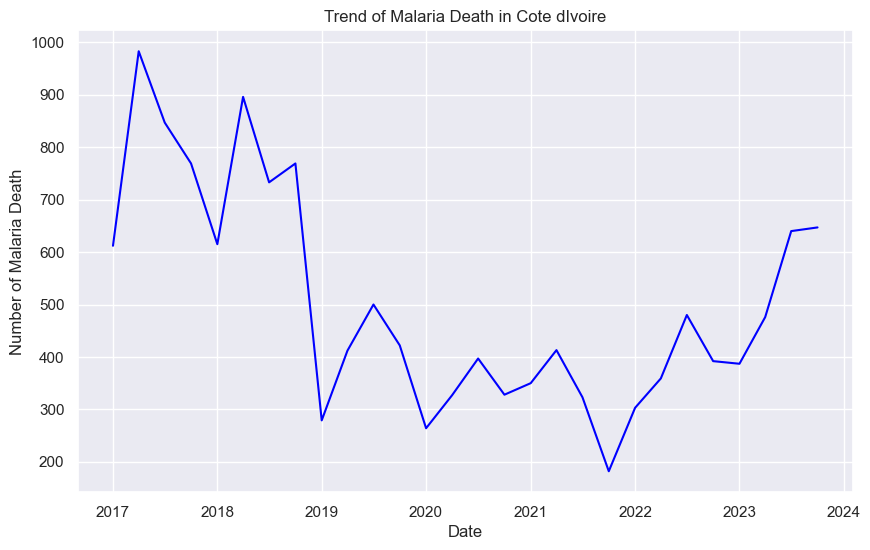

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Malaria_death'], color='blue')
plt.title('Trend of Malaria Death in Cote dIvoire')
plt.xlabel('Date')
plt.ylabel('Number of Malaria Death')
plt.grid(True)
plt.show()

## Check the stationarity

### First test: Perform the rolling statistics

In [19]:
df['rollMean'] = df['Malaria_death'].rolling(window=4).mean()
df['rollStd'] = df['Malaria_death'].rolling(window=4).std()

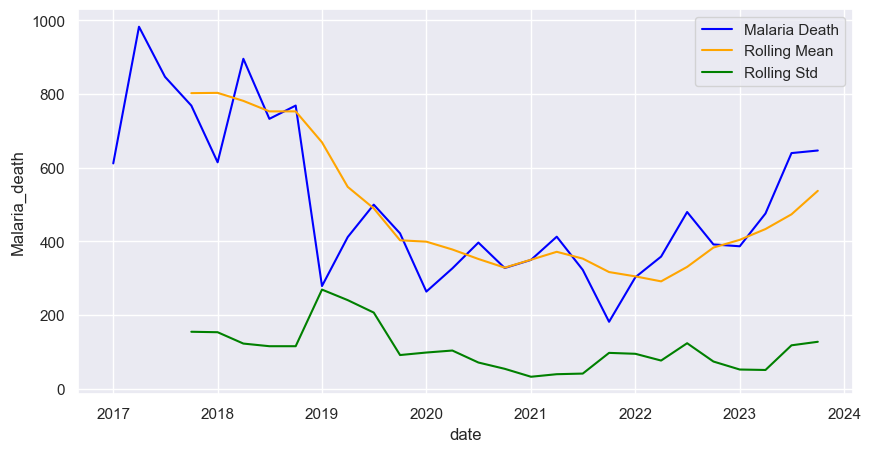

In [20]:
plt.figure(figsize=(10,5))
sns.lineplot(data=df, x=df.index, y=df['Malaria_death'], color = 'blue', label='Malaria Death')
sns.lineplot(data=df, x=df.index, y=df['rollMean'], color = 'orange', label='Rolling Mean')
sns.lineplot(data=df, x=df.index, y=df['rollStd'], color = 'green', label='Rolling Std')
plt.legend()

### The data is not stationnary

### Second test: Perform the Augmented Dickey-Fuller (ADF) test

In [21]:
# Import the ADF
from statsmodels.tsa.stattools import adfuller
from tabulate import tabulate

In [22]:
result = adfuller(df['Malaria_death'])

table = [
    ['Test statistic', result[0]],
    ['p-value', result[1]],
    ['Test interpretation', 'The data is stationary' if result[1] < 0.05 else 'The data is not stationary']
]

# Tabulate the results
print(tabulate(table, headers=['Métrique', 'Valeur'], tablefmt='github'))

| Métrique            | Valeur                     |
|---------------------|----------------------------|
| Test statistic      | -1.7220157286340485        |
| p-value             | 0.4198064927300434         |
| Test interpretation | The data is not stationary |


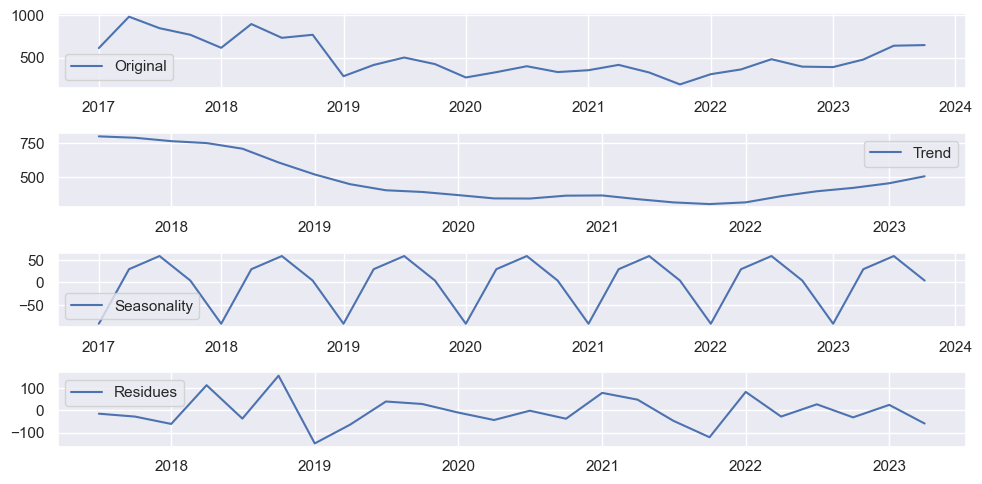

In [23]:
# Perform seasonal breakdown
decomposition = seasonal_decompose(df['Malaria_death'], model='additive')

# Extract the components from the breakdown
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Display the breakdown components
plt.figure(figsize=(10, 5))

plt.subplot(411)
plt.plot(df['Malaria_death'], label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residues')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

# Making the data stationary

## Create a function to easily test the stationarity of the different methods

In [24]:
def test_stationarity(dataFrame, var):
    dataFrame['rollMean'] = dataFrame[var].rolling(window=4).mean()
    dataFrame['rollstd'] = dataFrame[var].rolling(window=4).std()
    
    from statsmodels.tsa.stattools import adfuller
    adfTest = adfuller(dataFrame[var], autolag='AIC')
    stats = pd.Series(adfTest[0:4],index = ['The test statistic','p-value','#usedLags','#OBS'])
    print(stats)
    
    for key, values in adfTest[4].items():
        print('criticality',key,':',values)
        
    sns.lineplot(data=dataFrame, x=dataFrame.index, y=var, color = 'blue', label='var')    
    sns.lineplot(data=dataFrame, x=dataFrame.index, y='rollMean', color = 'orange', label='Rolling Mean')
    sns.lineplot(data=dataFrame, x=dataFrame.index, y='rollstd', color = 'green', label='Rolling Std')
    plt.legend()

The test statistic    -1.722016
p-value                0.419806
#usedLags              4.000000
#OBS                  23.000000
dtype: float64
criticality 1% : -3.7529275211638033
criticality 5% : -2.998499866852963
criticality 10% : -2.6389669754253307


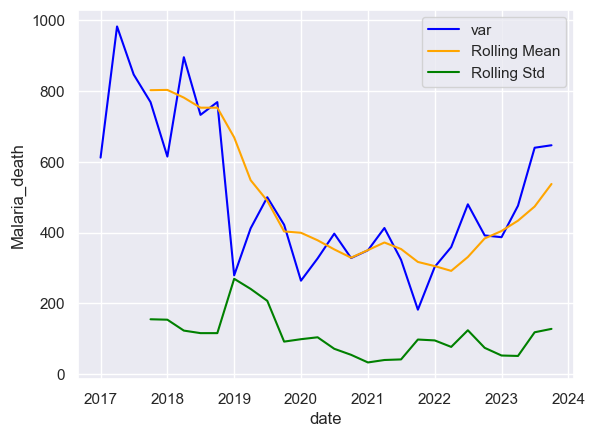

In [25]:
# Let's try if the function works well
test_stationarity(df,'Malaria_death')

In [26]:
df.head(2)

,Malaria_death,rollMean,rollStd,rollstd
date,,,,
2017-01-01,612,NaN,NaN,NaN
2017-04-01,983,NaN,NaN,NaN


In [27]:
death_df = df[['Malaria_death']]
death_df.head(2)

,Malaria_death
date,
2017-01-01,612
2017-04-01,983


## First method: Time shift transformation

In [28]:
# Time Shift
death_df['shift'] = death_df['Malaria_death'].shift()
death_df['shiftdiff'] = death_df['Malaria_death'] - death_df['shift']
death_df.head(2)

C:\Users\m_tap\AppData\Local\Temp\ipykernel_12740\664884276.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  death_df['shift'] = death_df['Malaria_death'].shift()
C:\Users\m_tap\AppData\Local\Temp\ipykernel_12740\664884276.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  death_df['shiftdiff'] = death_df['Malaria_death'] - death_df['shift']


,Malaria_death,shift,shiftdiff
date,,,
2017-01-01,612,NaN,NaN
2017-04-01,983,612.0,371.0


C:\Users\m_tap\AppData\Local\Temp\ipykernel_12740\3576771715.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame['rollMean'] = dataFrame[var].rolling(window=4).mean()
C:\Users\m_tap\AppData\Local\Temp\ipykernel_12740\3576771715.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame['rollstd'] = dataFrame[var].rolling(window=4).std()


The test statistic    -4.334642
p-value                0.000387
#usedLags              1.000000
#OBS                  25.000000
dtype: float64
criticality 1% : -3.7238633119999998
criticality 5% : -2.98648896
criticality 10% : -2.6328004


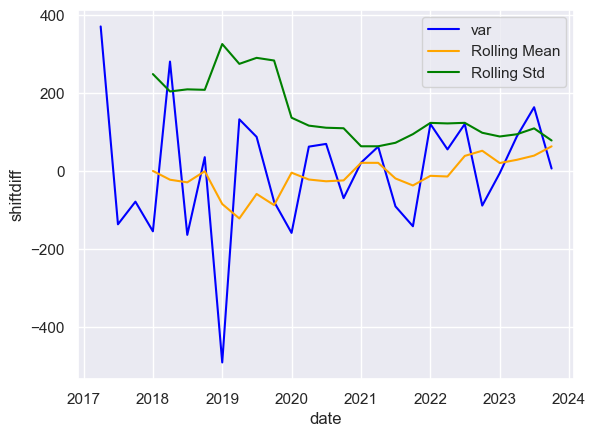

In [29]:
# Test the stationarity of the Time Shift Method
test_stationarity(death_df.dropna(),'shiftdiff')

### The shift transformation result is closed to a stationary data as the Test Statistic is less than the critical values and the p-value is less than 0.05. Let look the other data transformation results.

### Second method: Log transformation

In [30]:
log_df = df[['Malaria_death']]
log_df['log'] = np.log(log_df['Malaria_death'])
log_df.head()

C:\Users\m_tap\AppData\Local\Temp\ipykernel_12740\2826252657.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_df['log'] = np.log(log_df['Malaria_death'])


,Malaria_death,log
date,,
2017-01-01,612,6.416732
2017-04-01,983,6.890609
2017-07-01,847,6.741701
2017-10-01,769,6.645091
2018-01-01,615,6.421622


C:\Users\m_tap\AppData\Local\Temp\ipykernel_12740\3576771715.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame['rollMean'] = dataFrame[var].rolling(window=4).mean()


The test statistic    -2.189918
p-value                0.209925
#usedLags              0.000000
#OBS                  27.000000
dtype: float64
criticality 1% : -3.6996079738860943
criticality 5% : -2.9764303469999494
criticality 10% : -2.627601001371742


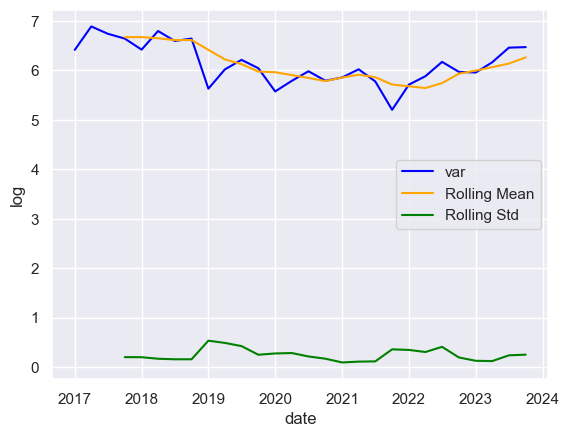

In [31]:
test_stationarity(log_df,'log')

### The Log transformation does not make the data stationary.

In [32]:
### The Square Root Transformation

In [33]:
sqrt_df = df[['Malaria_death']]
sqrt_df['sqrt'] = np.sqrt(df['Malaria_death'])
sqrt_df.head()

C:\Users\m_tap\AppData\Local\Temp\ipykernel_12740\2461798256.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sqrt_df['sqrt'] = np.sqrt(df['Malaria_death'])


,Malaria_death,sqrt
date,,
2017-01-01,612,24.738634
2017-04-01,983,31.352831
2017-07-01,847,29.103264
2017-10-01,769,27.730849
2018-01-01,615,24.799194


C:\Users\m_tap\AppData\Local\Temp\ipykernel_12740\3576771715.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame['rollMean'] = dataFrame[var].rolling(window=4).mean()


The test statistic    -2.151376
p-value                0.224364
#usedLags              1.000000
#OBS                  26.000000
dtype: float64
criticality 1% : -3.7112123008648155
criticality 5% : -2.981246804733728
criticality 10% : -2.6300945562130176


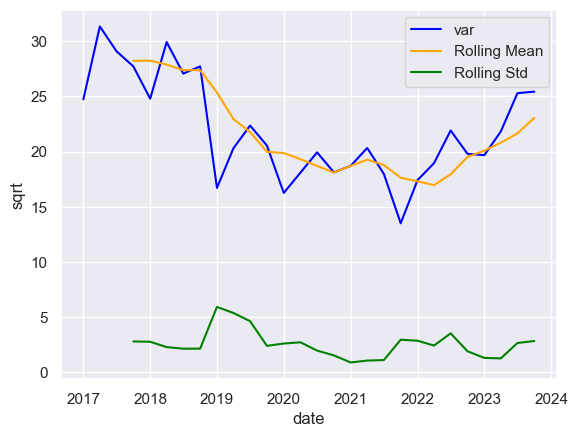

In [34]:
test_stationarity(sqrt_df,'sqrt')

### The Square Root transformation does not make the data stationary

### Let's try the Cube Root Transformation (cbrt)

In [35]:
cbrt_df = df[['Malaria_death']]
cbrt_df['cbrt'] = np.cbrt(df['Malaria_death'])
cbrt_df.head()

C:\Users\m_tap\AppData\Local\Temp\ipykernel_12740\1178074975.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cbrt_df['cbrt'] = np.cbrt(df['Malaria_death'])


,Malaria_death,cbrt
date,,
2017-01-01,612,8.490185
2017-04-01,983,9.943009
2017-07-01,847,9.461525
2017-10-01,769,9.161687
2018-01-01,615,8.504035


C:\Users\m_tap\AppData\Local\Temp\ipykernel_12740\3576771715.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame['rollMean'] = dataFrame[var].rolling(window=4).mean()


The test statistic    -2.152257
p-value                0.224027
#usedLags              1.000000
#OBS                  26.000000
dtype: float64
criticality 1% : -3.7112123008648155
criticality 5% : -2.981246804733728
criticality 10% : -2.6300945562130176


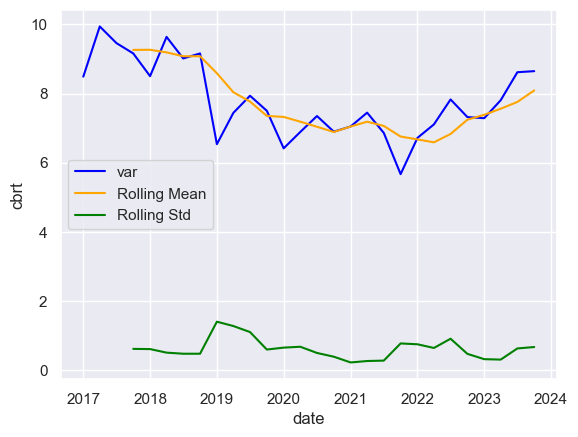

In [36]:
test_stationarity(cbrt_df,'cbrt')

In [37]:
# Combinaison of Log and Square Root
log_df2 = log_df[['Malaria_death','log']]
log_df2['logsqrt'] = np.sqrt(log_df['log'])
log_df2.head()

C:\Users\m_tap\AppData\Local\Temp\ipykernel_12740\2575523462.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_df2['logsqrt'] = np.sqrt(log_df['log'])


,Malaria_death,log,logsqrt
date,,,
2017-01-01,612,6.416732,2.533127
2017-04-01,983,6.890609,2.624997
2017-07-01,847,6.741701,2.596479
2017-10-01,769,6.645091,2.577807
2018-01-01,615,6.421622,2.534092


The test statistic    -2.217495
p-value                0.199957
#usedLags              0.000000
#OBS                  27.000000
dtype: float64
criticality 1% : -3.6996079738860943
criticality 5% : -2.9764303469999494
criticality 10% : -2.627601001371742


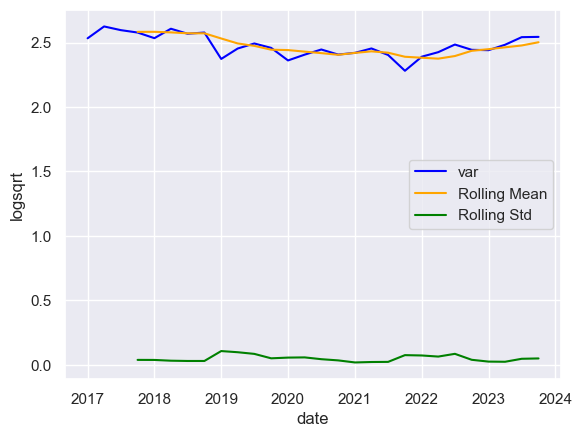

In [38]:
test_stationarity(log_df2,'logsqrt')

In [39]:
# Combinaison of Log and Cube Root
log_df2 = log_df[['Malaria_death','log']]
log_df2['logcbrt'] = np.cbrt(log_df['log'])
log_df2.head()

C:\Users\m_tap\AppData\Local\Temp\ipykernel_12740\1210578653.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_df2['logcbrt'] = np.cbrt(log_df['log'])


,Malaria_death,log,logcbrt
date,,,
2017-01-01,612,6.416732,1.858252
2017-04-01,983,6.890609,1.902914
2017-07-01,847,6.741701,1.889107
2017-10-01,769,6.645091,1.880040
2018-01-01,615,6.421622,1.858724


The test statistic    -2.227270
p-value                0.196497
#usedLags              0.000000
#OBS                  27.000000
dtype: float64
criticality 1% : -3.6996079738860943
criticality 5% : -2.9764303469999494
criticality 10% : -2.627601001371742


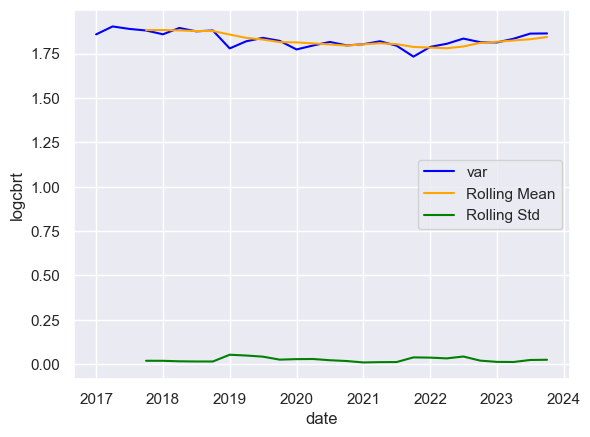

In [40]:
test_stationarity(log_df2,'logcbrt')

In [41]:
death_df['shift'] = death_df['Malaria_death'].shift()
death_df['shiftdiff'] = death_df['Malaria_death'] - death_df['shift']
death_df['abshift'] = abs(death_df['shiftdiff'])
death_df.head()

C:\Users\m_tap\AppData\Local\Temp\ipykernel_12740\136076408.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  death_df['shift'] = death_df['Malaria_death'].shift()
C:\Users\m_tap\AppData\Local\Temp\ipykernel_12740\136076408.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  death_df['shiftdiff'] = death_df['Malaria_death'] - death_df['shift']


,Malaria_death,shift,shiftdiff,abshift
date,,,,
2017-01-01,612,NaN,NaN,NaN
2017-04-01,983,612.0,371.0,371.0
2017-07-01,847,983.0,-136.0,136.0
2017-10-01,769,847.0,-78.0,78.0
2018-01-01,615,769.0,-154.0,154.0


C:\Users\m_tap\AppData\Local\Temp\ipykernel_12740\3576771715.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame['rollMean'] = dataFrame[var].rolling(window=4).mean()
C:\Users\m_tap\AppData\Local\Temp\ipykernel_12740\3576771715.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame['rollstd'] = dataFrame[var].rolling(window=4).std()


The test statistic    -3.694915
p-value                0.004185
#usedLags              1.000000
#OBS                  25.000000
dtype: float64
criticality 1% : -3.7238633119999998
criticality 5% : -2.98648896
criticality 10% : -2.6328004


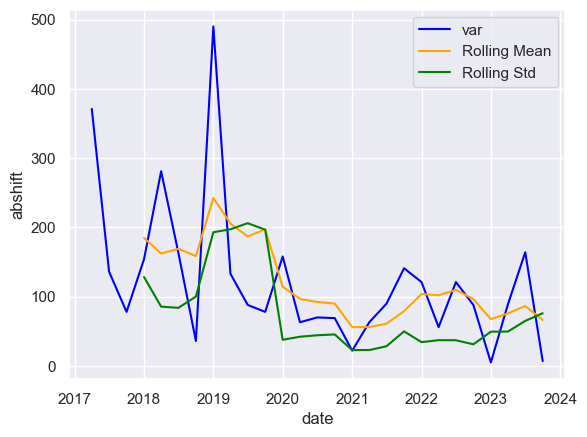

In [42]:
test_stationarity(death_df.dropna(),'abshift')

### The ShiftDift transformation shared the best result. Let's move forward with it.

# Build the model

In [43]:
death_df = df[['Malaria_death']].copy(deep=True)

In [44]:
death_df['firstDiff'] = death_df['Malaria_death'].diff()
death_df['Diff4'] = death_df['Malaria_death'].diff(4)

In [45]:
death_df['shift'] = death_df['Malaria_death'].shift()
death_df['shiftdiff'] = death_df['Malaria_death'] - death_df['shift']

In [46]:
death_df.head()

,Malaria_death,firstDiff,Diff4,shift,shiftdiff
date,,,,,
2017-01-01,612,NaN,NaN,NaN,NaN
2017-04-01,983,371.0,NaN,612.0,371.0
2017-07-01,847,-136.0,NaN,983.0,-136.0
2017-10-01,769,-78.0,NaN,847.0,-78.0
2018-01-01,615,-154.0,3.0,769.0,-154.0


## Buill ARIMA Model

### Figure Out Order For ARIMA Model

In [47]:
# from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


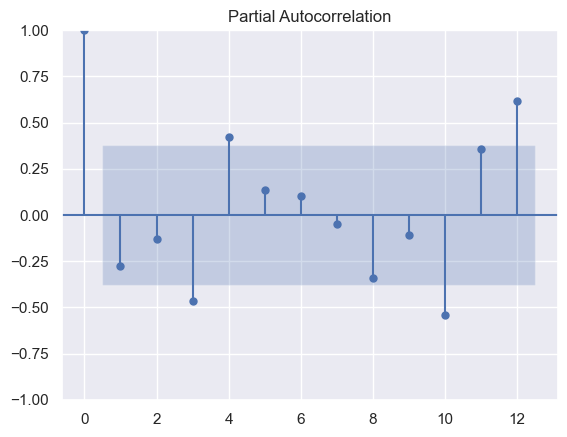

In [48]:
plot_pacf(death_df['shiftdiff'].dropna(), lags=12);

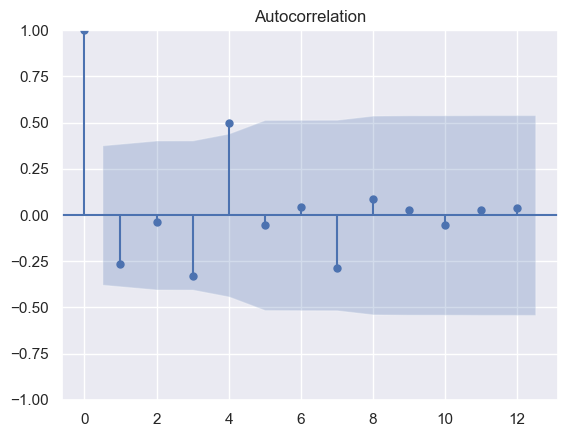

In [49]:
plot_acf(death_df['shiftdiff'].dropna(), lags=12);

In [50]:
# We can install pmdarima to get the number of differencing

from pmdarima.arima.utils import ndiffs

In [51]:
from statsmodels.tsa.stattools import adfuller

In [52]:
ndiffs(death_df['Malaria_death'].dropna(), test='adf')

1

In [53]:
# Based on the pacf and acf plots, and the ndiffs value, we can determine the different values of the ARIMA model.
# p= 3, or 4,or 10, or 12  d=1, q=4
# (3,1,4), or (4,1,4), or (10,1,4), (12,1,4)

In [54]:
train = death_df[:round(len(death_df)*70/100)]
test = death_df[round(len(death_df)*70/100):]

In [55]:
model = ARIMA(death_df['Malaria_death'],order = (12,1,4))
model_fit = model.fit()
prediction = model_fit.predict(start = test.index[0], end = test.index[-1])

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [56]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:          Malaria_death   No. Observations:                   28
Model:                ARIMA(12, 1, 4)   Log Likelihood                -162.492
Date:                Fri, 05 Apr 2024   AIC                            358.984
Time:                        04:08:17   BIC                            381.013
Sample:                    01-01-2017   HQIC                           365.535
                         - 10-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0167      0.701      0.024      0.981      -1.356       1.390
ar.L2         -0.8948      1.254     -0.714      0.475      -3.353       1.563
ar.L3         -0.1383      0.846     -0.164      0.8

In [57]:
death_df['arimaPred'] = prediction
death_df.tail()

,Malaria_death,firstDiff,Diff4,shift,shiftdiff,arimaPred
date,,,,,,
2022-10-01,392,-88.0,210.0,480.0,-88.0,334.865372
2023-01-01,387,-5.0,84.0,392.0,-5.0,354.272845
2023-04-01,476,89.0,117.0,387.0,89.0,477.104091
2023-07-01,640,164.0,160.0,476.0,164.0,731.922109
2023-10-01,647,7.0,255.0,640.0,7.0,602.639614


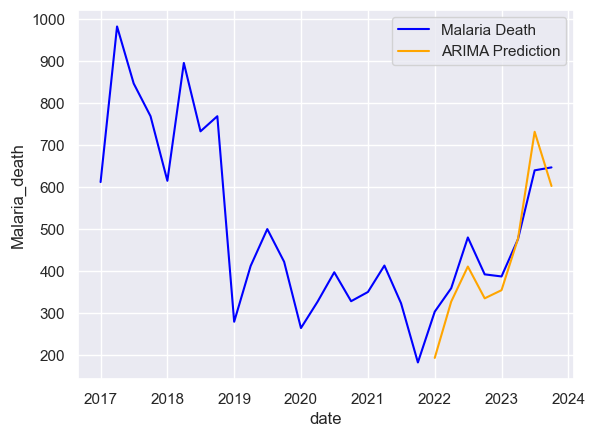

In [58]:
death_df.dropna()
sns.lineplot(data=death_df, x=death_df.index, y='Malaria_death', color='blue', label='Malaria Death')
sns.lineplot(data=death_df, x=death_df.index, y='arimaPred', color='orange', label='ARIMA Prediction')
plt.legend()

In [59]:
from sklearn.metrics import mean_squared_error

In [60]:
np.sqrt(mean_squared_error(test['Malaria_death'], prediction))

63.973281724593015

### The Root Mean Square Error (RMSE) is low (less than 180). This means that the model is accurate.

In [61]:
futureDate = pd.DataFrame(pd.date_range(start='2023-10-01', end='2024-08-30', freq='QS'), columns=['date'])
futureDate.set_index('date',inplace=True)
futureDate.head()

""
date
2023-10-01
2024-01-01
2024-04-01
2024-07-01


In [62]:
import matplotlib.pyplot as plt
import numpy as np
import calendar

In [63]:
model = ARIMA(death_df['Malaria_death'], order=(10,1,4))
results = model.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible start

In [64]:
forecast_steps = 4 
forecast_index = pd.date_range(df.index[-1], periods=forecast_steps + 1, freq='Q')[1:] 
forecast = results.get_forecast(steps=forecast_steps, index=forecast_index) 

In [65]:
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

In [66]:
import matplotlib.pyplot as plt
import datetime
import matplotlib.units as munits
import matplotlib.dates as mdates
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import matplotlib.dates as mdates

In [67]:
forecast = model_fit.predict(start=futureDate.index[0], end=futureDate.index[-1])
forecast

2023-10-01    602.639614
2024-01-01    372.482596
2024-04-01    417.590892
2024-07-01    516.445550
Freq: QS-OCT, Name: predicted_mean, dtype: float64

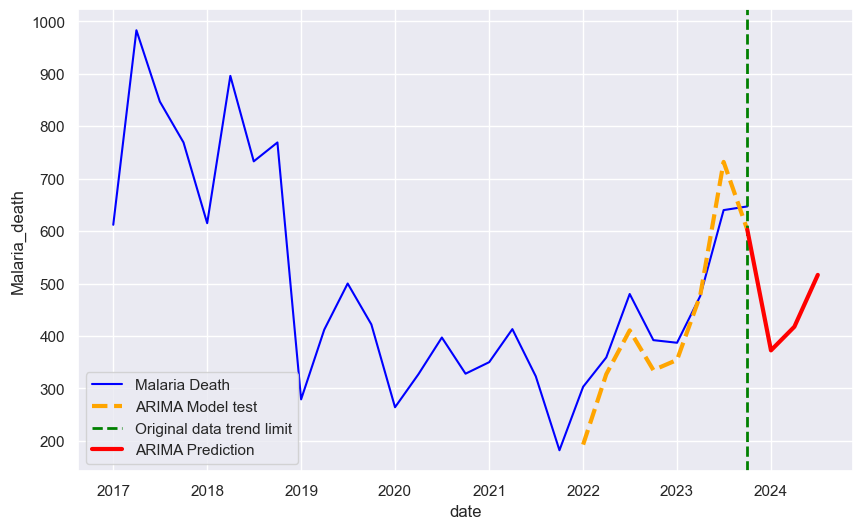

In [68]:
plt.figure(figsize=(10, 6))
death_df.dropna()
sns.lineplot(data=death_df, x=death_df.index, y='Malaria_death', color='blue', label='Malaria Death')
sns.lineplot(data=death_df, x=death_df.index, y='arimaPred', color='orange',linestyle='dashed',linewidth=3, label='ARIMA Model test')
plt.axvline(datetime.datetime(2023, 10, 1), color='green',linestyle='dashed',linewidth=2,label='Original data trend limit')
sns.lineplot(data=forecast, x=forecast.index, y=forecast, color='red',linewidth=3, label='ARIMA Prediction')
# model_fit.predict(start=futureDate.index[0], end=futureDate.index[-1]).plot()
plt.legend()